<a href="https://colab.research.google.com/github/ThePina/Machine-learning-final-project/blob/main/ProyectoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
import csv


#obtencion de los datos

In [2]:
#Creación del DataFrame con los datos del archivo csv descargado del url
url = 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='

data = requests.get(url)
lines = data.text.splitlines()
reader = csv.reader(lines,delimiter=';')
df = pd.DataFrame(reader)
df.drop([5], axis=1,inplace=True)
df.drop([0], axis=0,inplace=True)
df.columns = ["FECHA (YYMMDD)",	"HORA (HHMM)"	,"Registros validados"	,"Registros preliminares"	,"Registros no validados"]
df.reset_index()
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados
1,120707,0100,,,
2,120707,0200,,,
3,120707,0300,,,
4,120707,0400,,,
5,120707,0500,,,
...,...,...,...,...,...
82411,211130,1900,,3,
82412,211130,2000,,7,
82413,211130,2100,,7,
82414,211130,2200,,11,


#Analisis de datos


In [3]:
df=df.replace('',0.0)
df['Registros validados']=df['Registros validados'].str.replace(',','.').astype(float)
df['Registros preliminares']=df['Registros preliminares'].str.replace(',','.').astype(float)
df['Registros no validados']=df['Registros no validados'].str.replace(',','.').astype(float)
df=df.replace(np.nan,0.0)
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados
1,120707,0100,0.0,0.0,0.0
2,120707,0200,0.0,0.0,0.0
3,120707,0300,0.0,0.0,0.0
4,120707,0400,0.0,0.0,0.0
5,120707,0500,0.0,0.0,0.0
...,...,...,...,...,...
82411,211130,1900,0.0,3.0,0.0
82412,211130,2000,0.0,7.0,0.0
82413,211130,2100,0.0,7.0,0.0
82414,211130,2200,0.0,11.0,0.0


###Union de la fecha
Para la union de las fechas se tomo la "FECHA (YYMMDD)"	"HORA (HHMM)"	y se combinaron una sola celda para poder tener el formato "YYMMDDHHMM" y posteriromente pasarlo a el formato Date para poder trabajarlos de una manera eficiente durante el desarrollo.
De esta manera es posible asociar una fecha con una hora en una sola variable a los datos registrados.

In [4]:

df['Fecha'] =df['FECHA (YYMMDD)']+df['HORA (HHMM)']
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%y%m%d%H%M")
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,Fecha
1,120707,0100,0.0,0.0,0.0,2012-07-07 01:00:00
2,120707,0200,0.0,0.0,0.0,2012-07-07 02:00:00
3,120707,0300,0.0,0.0,0.0,2012-07-07 03:00:00
4,120707,0400,0.0,0.0,0.0,2012-07-07 04:00:00
5,120707,0500,0.0,0.0,0.0,2012-07-07 05:00:00
...,...,...,...,...,...,...
82411,211130,1900,0.0,3.0,0.0,2021-11-30 19:00:00
82412,211130,2000,0.0,7.0,0.0,2021-11-30 20:00:00
82413,211130,2100,0.0,7.0,0.0,2021-11-30 21:00:00
82414,211130,2200,0.0,11.0,0.0,2021-11-30 22:00:00


#Grafico de tiempo con los datos separados
A continuacion se muestra el grafico con la linea de tiempo con sus datos por separados, es decir Registros validados, Registros preliminares y Registros no validados.

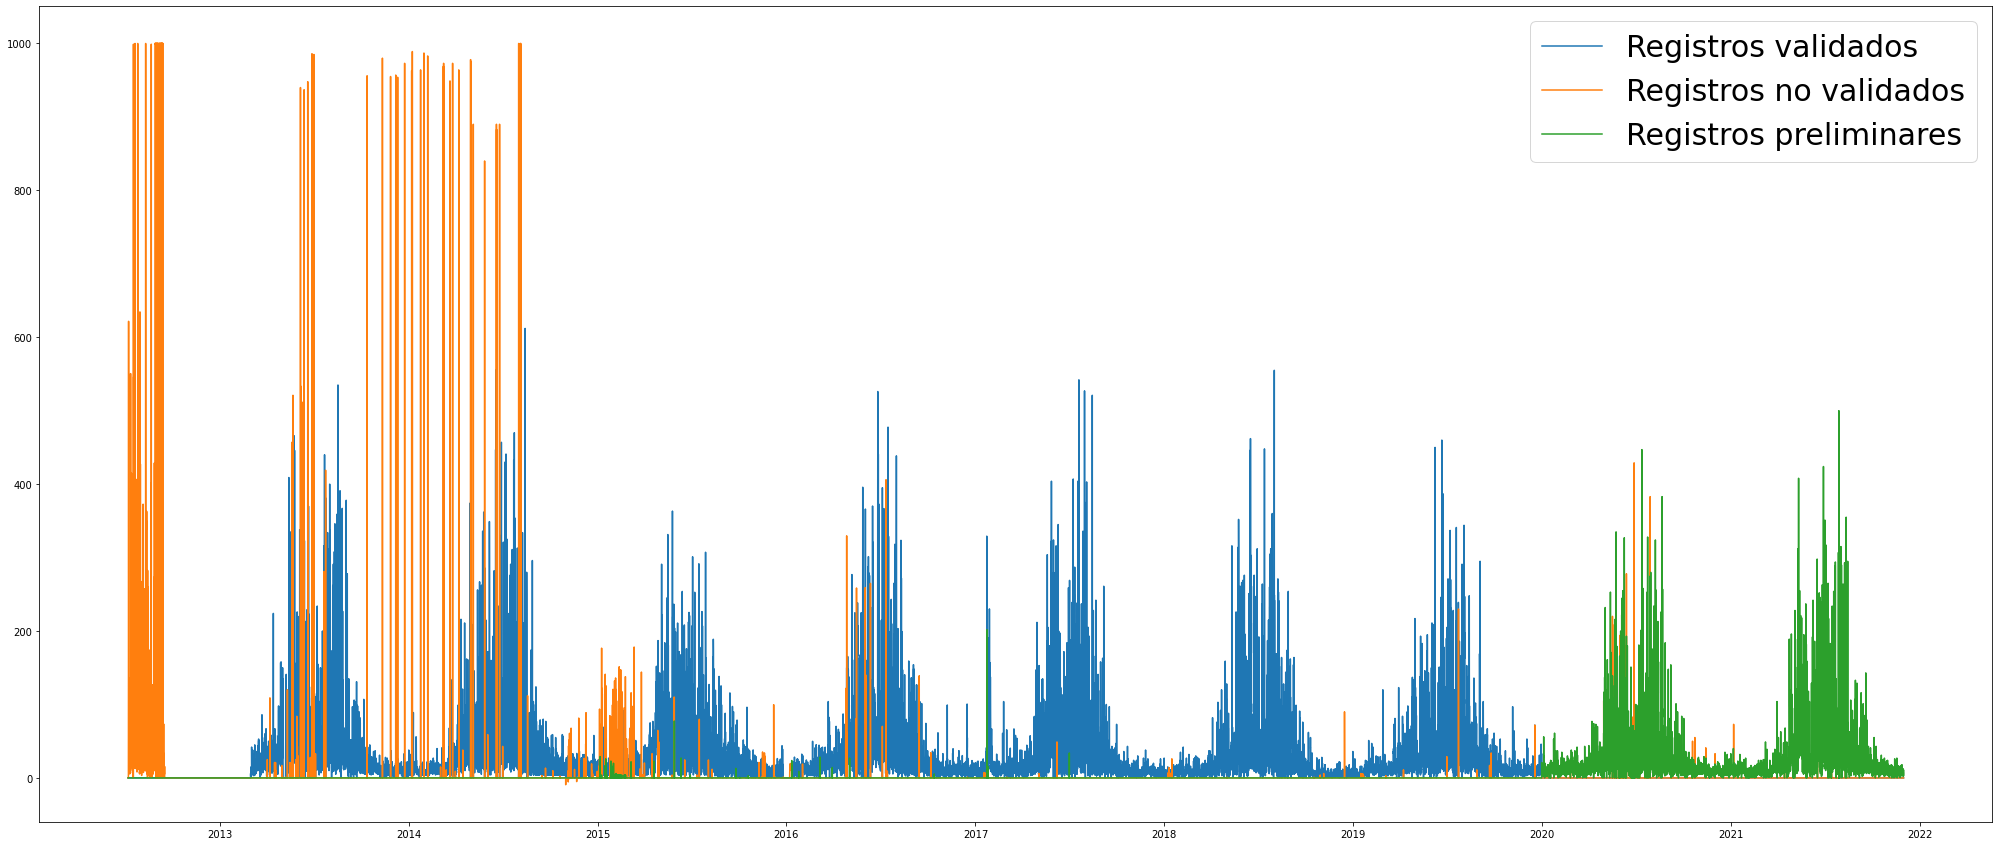

In [129]:
x = np.array(df['Fecha'])
y1 = np.array(df['Registros validados'])
y2 = np.array(df['Registros preliminares'])
y3 = np.array(df['Registros no validados'])
plt.figure(figsize=(35, 15))


plt.plot(x,y1,label="Registros validados")
plt.plot(x,y3,label="Registros no validados")
plt.plot(x,y2,label="Registros preliminares")

plt.legend(prop={'size': 30})

Como se puede observar los registros no validados en su gran mayoria se escapan de un rango razonable de los datos (datos atipicos), por lo que se opto por eliminar dichos datos para obtener los datos en un rango mas acotado, lo que ayudara a que el entrenamiento del modelo sea mas eficaz.

#Eliminacion de los registros no validados

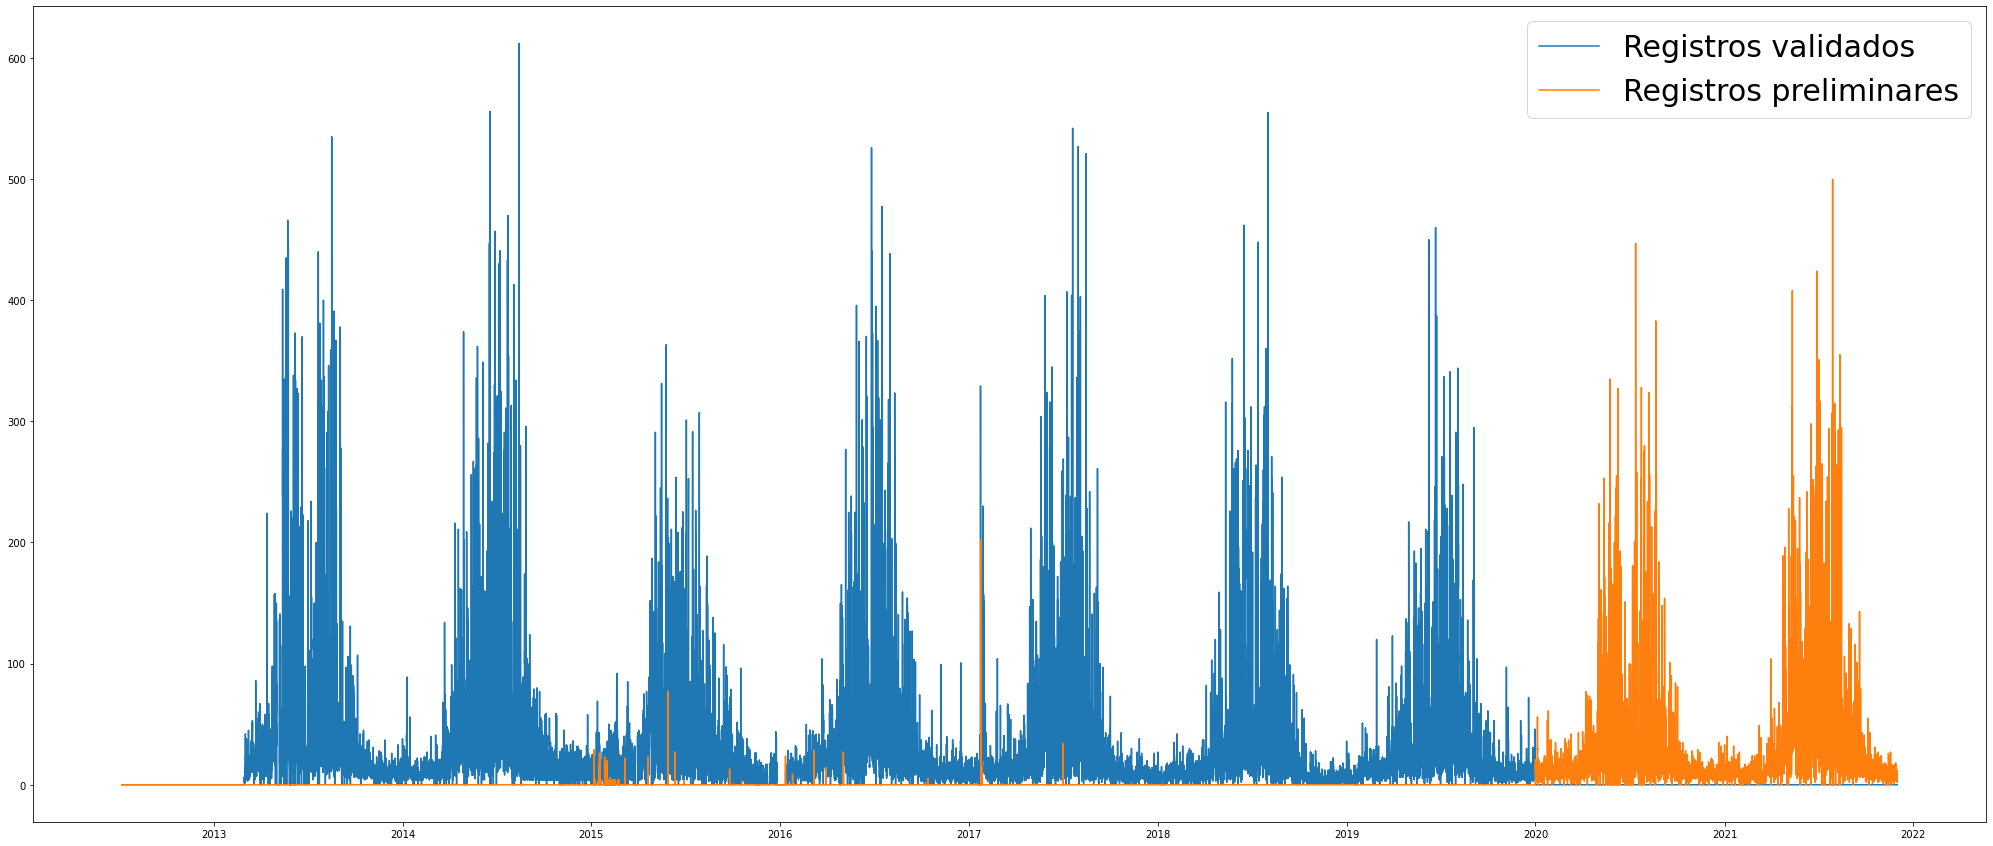

In [6]:
x = np.array(df['Fecha'])
y1 = np.array(df['Registros validados'])
y2 = np.array(df['Registros preliminares'])

plt.figure(figsize=(35, 15))


plt.plot(x,y1,label="Registros validados")
plt.plot(x,y2,label="Registros preliminares")
plt.legend(prop={'size': 30})

Como se puede observar los datos ya se encuentran en rango mas pequeño lo que ayudara al modelo en el entrenamiento, y tambien gracias a la eliminacion de esos datos podemos ver mas facilmente un patron en la linea temporal.

#Union de los datos
Como anteriermente se dijo se eliminaran los registros no validos, por lo que los registros generales que se usaran corresponen prelimianares o los validados dependiendo de cual sea el disponible. Ademas se eliminaran las fechas que no tengan registro, ya que esto podria alterar la fiabilidad del modelo que se utilizara.

In [65]:
df2=pd.DataFrame()
df2['Fecha']= df['Fecha']
df2['valor'] = df['Registros validados']+df['Registros preliminares']
#df2['valor Promedio'] = df2.valor.rolling(24).mean() 
df2 = df2[df2.valor != 0.0]
df2 = df2.reset_index()
df2

,index,Fecha,valor
0,5688,2013-03-01 00:00:00,6.0
1,5689,2013-03-01 01:00:00,3.0
2,5690,2013-03-01 02:00:00,4.0
3,5691,2013-03-01 03:00:00,4.0
4,5692,2013-03-01 04:00:00,2.0
...,...,...,...
74222,82411,2021-11-30 19:00:00,3.0
74223,82412,2021-11-30 20:00:00,7.0
74224,82413,2021-11-30 21:00:00,7.0
74225,82414,2021-11-30 22:00:00,11.0


#Promedio Diario
Tambien se calculara el promedio diario de los registros, para poder tener un modelo basado en días, lo que ayudara a ajustar el modelo ya que los datos tendran menos disperción.

In [54]:
dfMean=pd.DataFrame()
dfMean['fecha']=	df['FECHA (YYMMDD)']

dfMean['valor'] = df['Registros validados']+df['Registros preliminares']
dfMean = dfMean[dfMean.valor != 0.0]
grouped_df = dfMean.groupby("fecha")
mean_df = grouped_df.mean()
mean_df = mean_df.reset_index()
dfMean=(mean_df)

dfMean['fecha'] = pd.to_datetime(dfMean['fecha'], format="%y%m%d")



In [55]:
dfMean

,fecha,valor
0,2013-03-01,5.875000
1,2013-03-02,10.250000
2,2013-03-03,15.333333
3,2013-03-04,17.041667
4,2013-03-05,17.125000
...,...,...
3150,2021-11-26,8.750000
3151,2021-11-27,7.000000
3152,2021-11-28,8.333333
3153,2021-11-29,7.875000


#Grafico con los datos unidos
Grafico en el tiempo con los registros agrupados por horas y por promedio diario

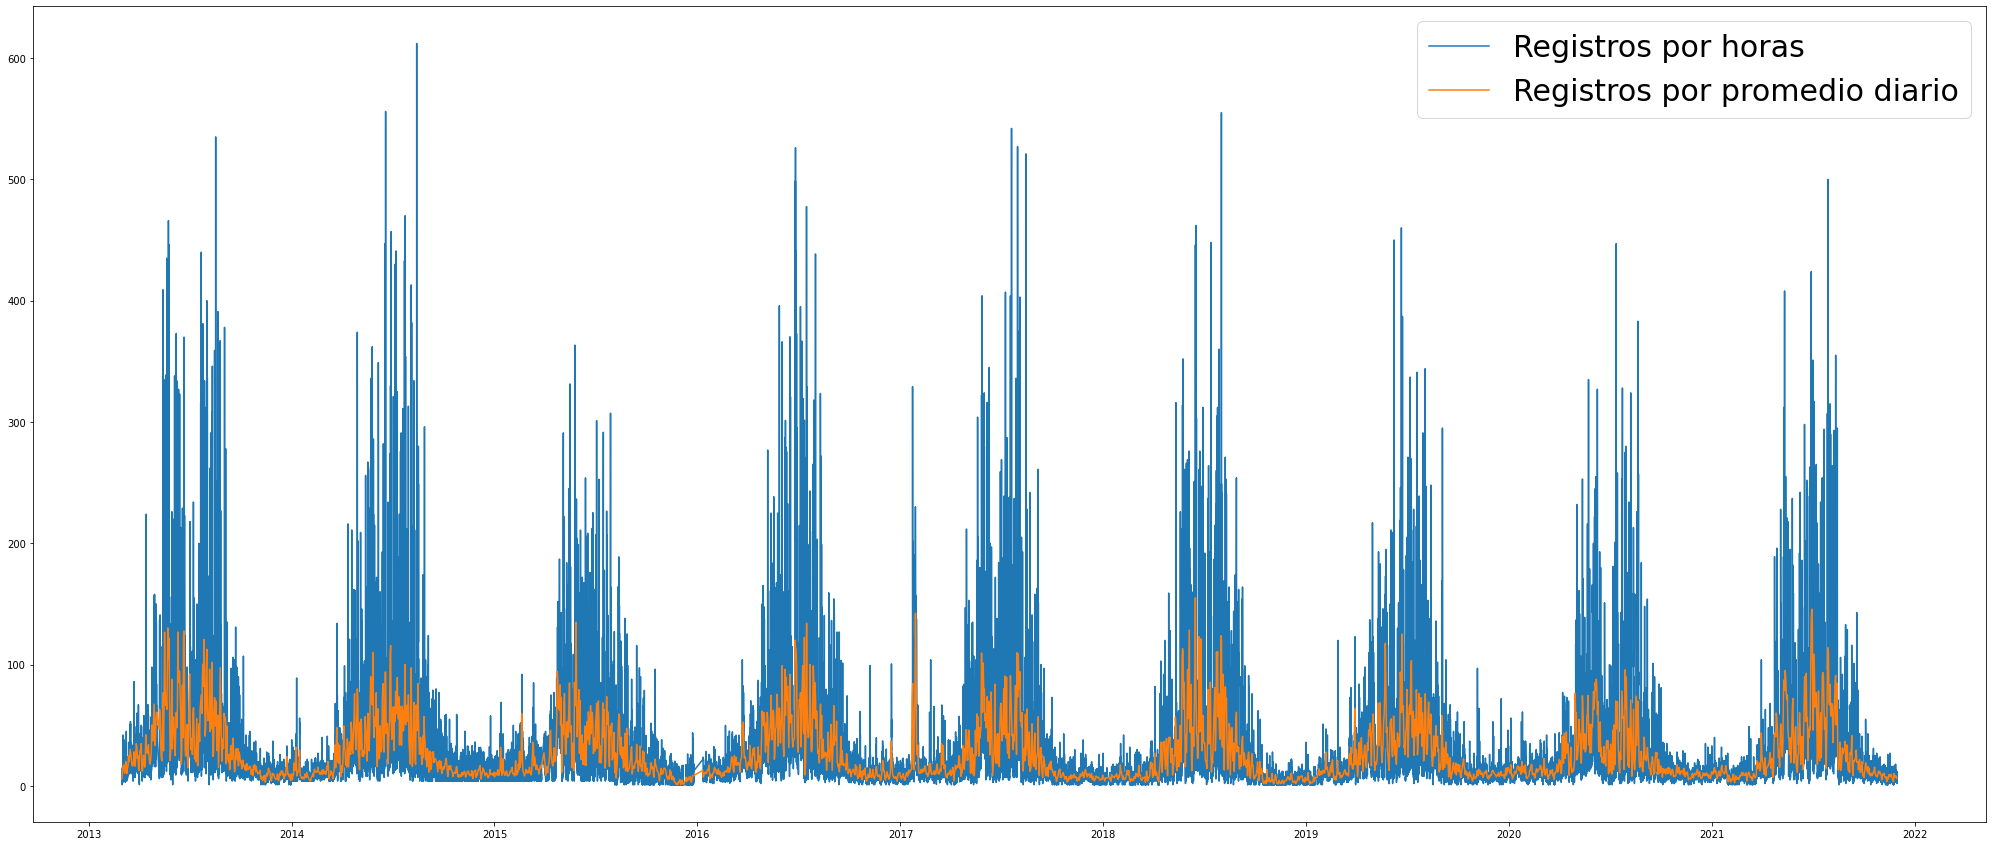

In [56]:
x1 = np.array(df2['Fecha'])
x2 = np.array(dfMean['fecha'])
y1 = np.array(df2['valor'])
y2 = np.array(dfMean['valor'])

plt.figure(figsize=(35, 15))
plt.plot(x1,y1,label="Registros por horas")
plt.plot(x2,y2,label="Registros por promedio diario")
plt.legend(prop={'size': 30})

Como se puede observar en el grafico anterior los registros por promedio diario muestran una dispercion menor a los registros por hora, lo cual deberia arrogar mejores resultados en el modelo, por lo que realizaran pruebas con ambos tipos de agrupaciones de datos en el modelo.

#Model Prophet datos por horas

In [67]:
#datos de entrenamiento hasta el 2019-01-01 y el resto de pruebas
train_range = df2[df2.Fecha < '2019-01-01'].index
test_range = df2[(df2.Fecha >= '2019-01-01')].index
train_range

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            49180, 49181, 49182, 49183, 49184, 49185, 49186, 49187, 49188,
            49189],
           dtype='int64', length=49190)

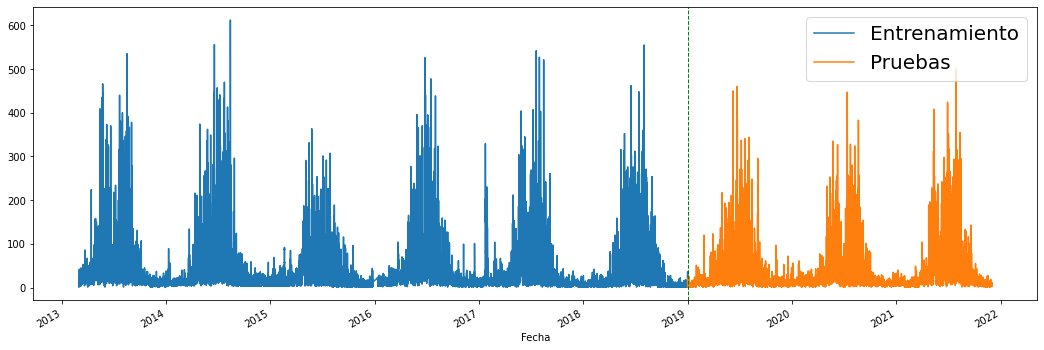

In [113]:
fig, ax = plt.subplots(figsize=(18,6))
df2.loc[train_range].plot(x="Fecha", y="valor", ax=ax, label="Entrenamiento")
df2.loc[test_range].plot(x="Fecha", y="valor", ax=ax, label="Pruebas")

plt.axvline(pd.to_datetime(str(df2.loc[test_range].Fecha.values[0])), c='green', ls='--', lw=1)
plt.legend(prop={'size': 20})

In [122]:
df_prophet_train = df2.loc[train_range][["Fecha", "valor"]]
df_prophet_train.columns = ["ds", "y"]
model = Prophet()
model.fit(df_prophet_train);

In [123]:
df_prophet_test = df2.loc[test_range][["Fecha", "valor"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])

forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df2.loc[test_range].valor.values

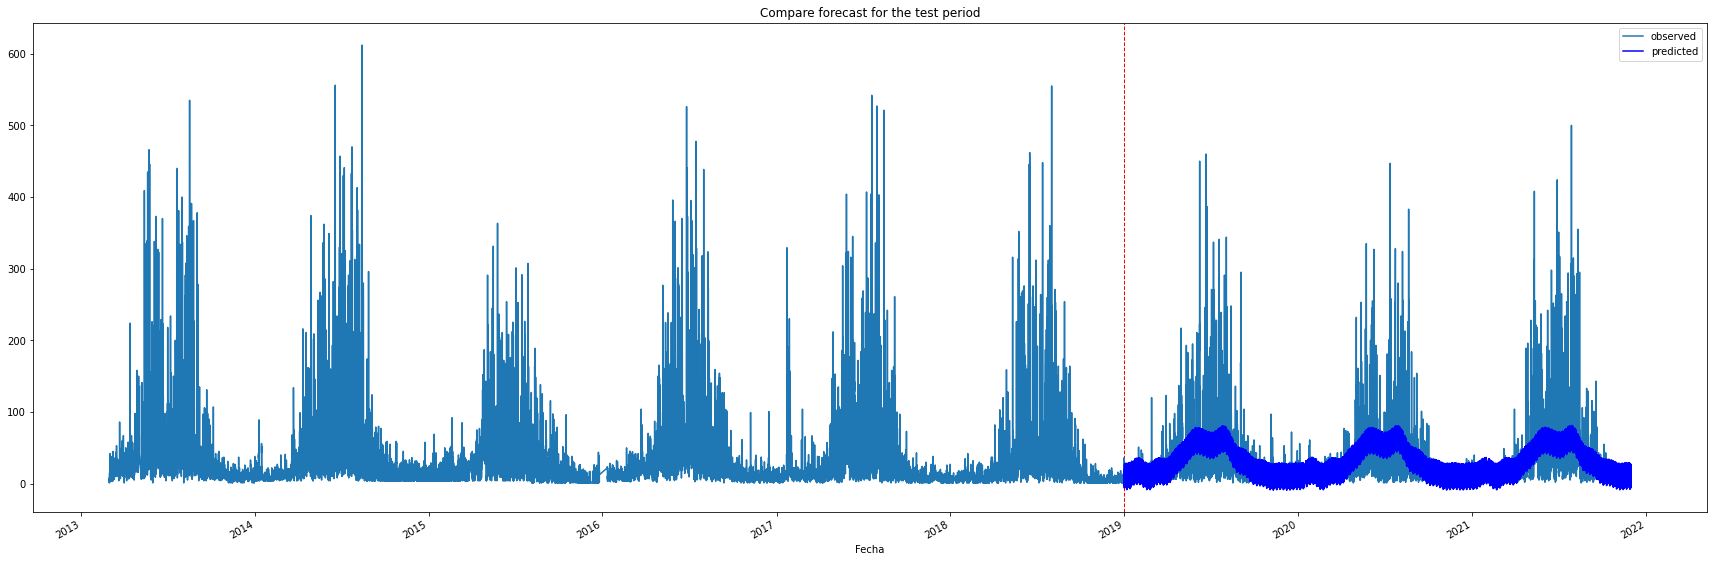

In [124]:
fig, ax = plt.subplots(figsize=(30,10))


plt.axvline(pd.to_datetime(str(df2.loc[test_range].Fecha.values[0])), c='red', ls='--', lw=1)
df2.plot(x="Fecha", y="valor", ax=ax, label="observed")

ax.plot(pd.to_datetime(df2.loc[test_range].Fecha.values), yhat_test,
        color="blue", label="predicted")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.show();

Como se puede ver los resultados del modelo se parecen levemente a los a los registros reales, esto de puede deber a que la dispercion de los datos es muy elevada.

In [125]:
future = model.make_future_dataframe(periods=1095)
forecast2 = model.predict(future)


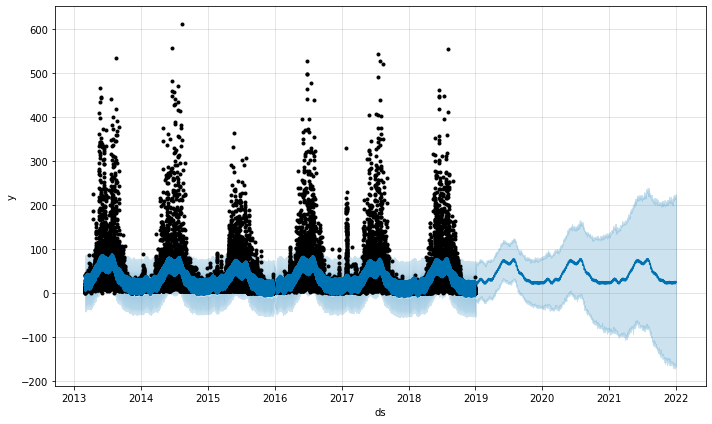

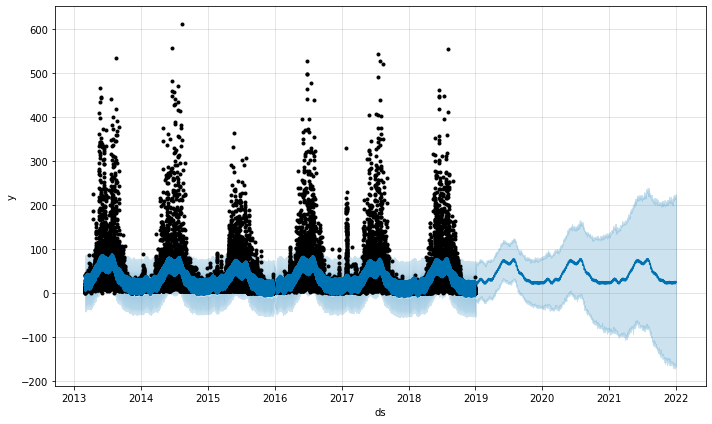

In [126]:
model.plot(forecast2)

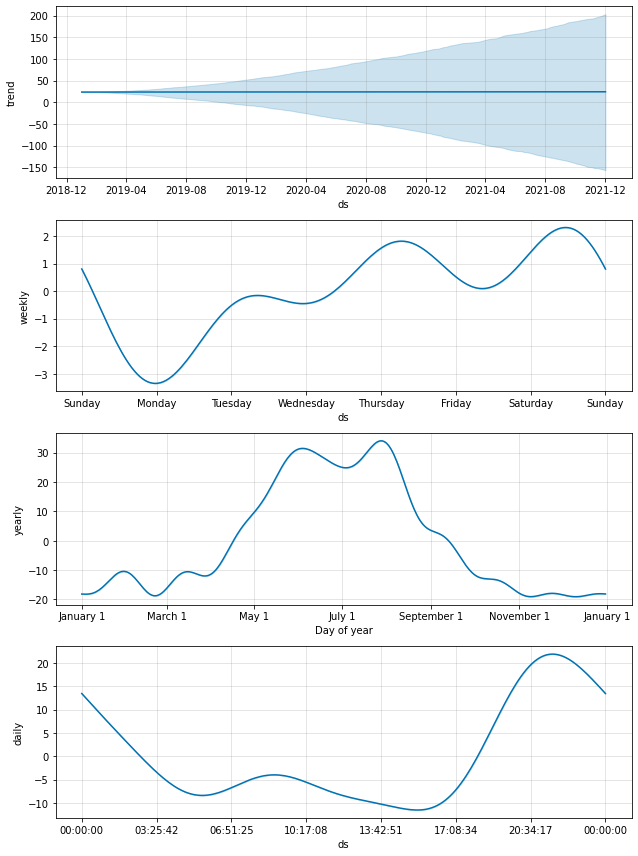

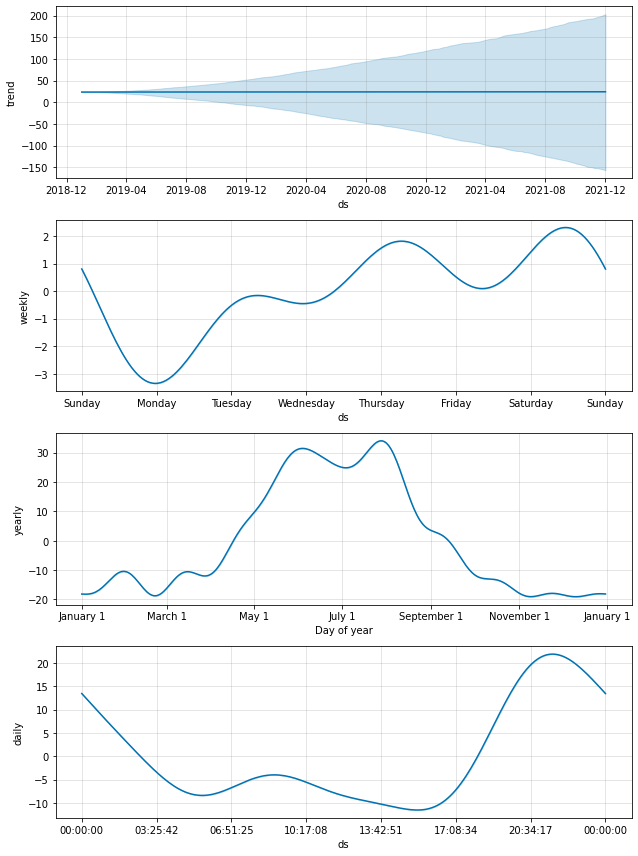

In [127]:
model.plot_components(forecast)

#Model Prophet datos por promedio diario

In [66]:
#datos de entrenamiento hasta el 2019-01-01 y el resto de pruebas
train_range_Mean = dfMean[dfMean.fecha < '2019-01-01'].index
test_range_Mean = dfMean[(dfMean.fecha >= '2019-01-01')].index
train_range_Mean

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095],
           dtype='int64', length=2096)

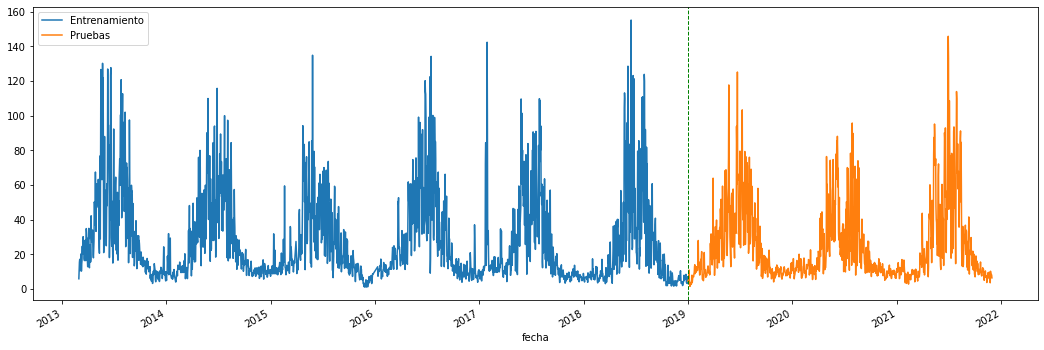

In [97]:
fig, ax = plt.subplots(figsize=(18,6))
dfMean.loc[train_range_Mean].plot(x="fecha", y="valor", ax=ax, label="Entrenamiento")
dfMean.loc[test_range_Mean].plot(x="fecha", y="valor", ax=ax, label="Pruebas")

plt.axvline(pd.to_datetime(str(dfMean.loc[test_range_Mean].fecha.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

In [98]:
df_prophet_train = dfMean.loc[train_range_Mean][["fecha", "valor"]]
df_prophet_train.columns = ["ds", "y"]
model_Mean = Prophet()
model_Mean.fit(df_prophet_train);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [118]:
df_prophet_test = dfMean.loc[test_range_Mean][["fecha", "valor"]]
df_prophet_test.columns = ["ds", "y"]

forecast_Mean = model_Mean.predict(df_prophet_test[['ds']])

forecast_ci_Mean = forecast_Mean[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast_Mean.yhat.values
y_test = df2.loc[test_range_Mean].valor.values

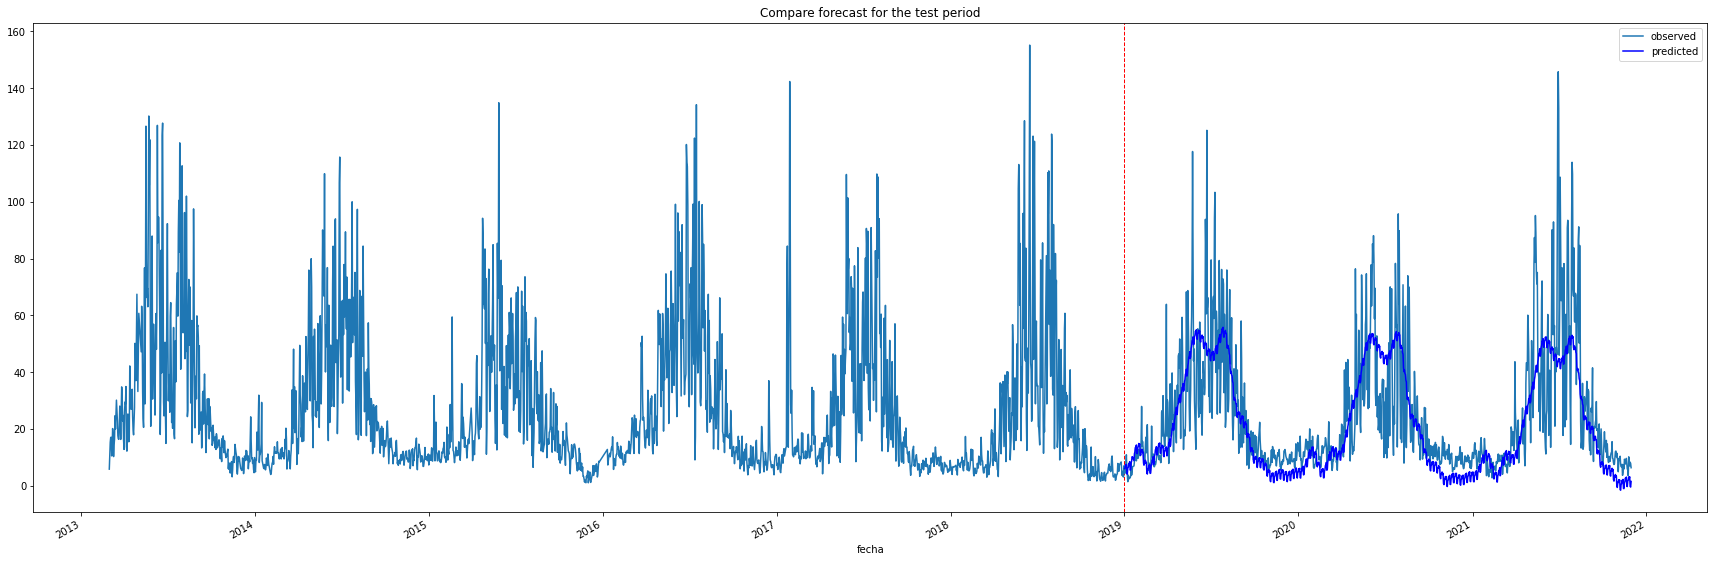

In [119]:
fig, ax = plt.subplots(figsize=(30,10))


plt.axvline(pd.to_datetime(str(dfMean.loc[test_range_Mean].fecha.values[0])), c='red', ls='--', lw=1)
dfMean.plot(x="fecha", y="valor", ax=ax, label="observed")

ax.plot(pd.to_datetime(dfMean.loc[test_range_Mean].fecha.values), yhat_test,
        color="blue", label="predicted")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.show();

Como se puede observar en el grafico anterior, la predicciond el modelo se asemeja bastante a los datos registrados en el periodo pruebas, esto se debe a que la dispercion de los datos no cuenta con gran disperción, lo que ayuda al modelo a encontrar patrones mas solidos.

In [120]:
future_Mean = model_Mean.make_future_dataframe(periods=1000)
forecast2__Mean = model_Mean.predict(future_Mean)


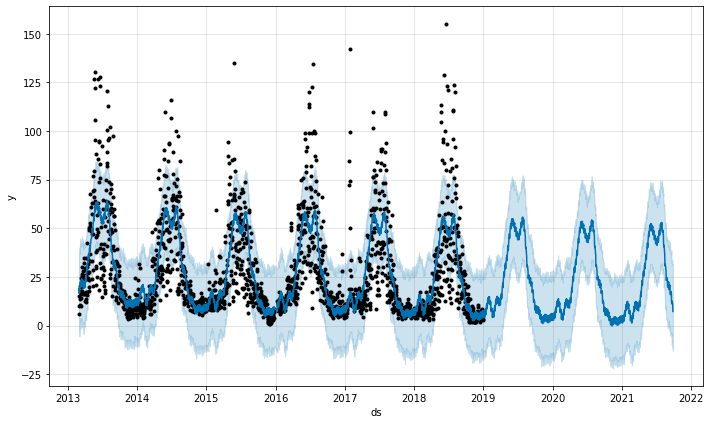

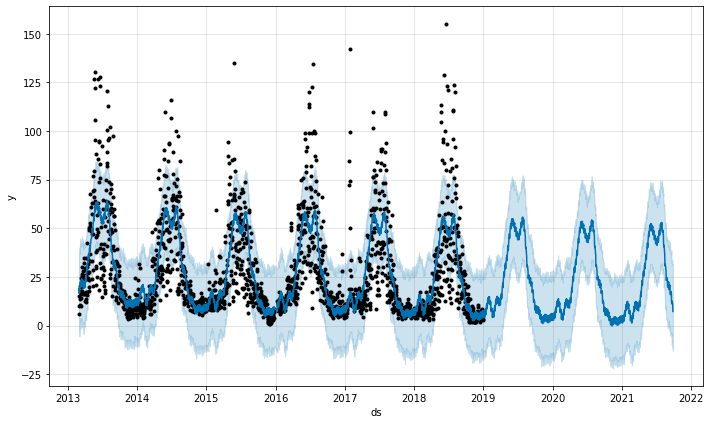

In [121]:
model_Mean.plot(forecast2__Mean)

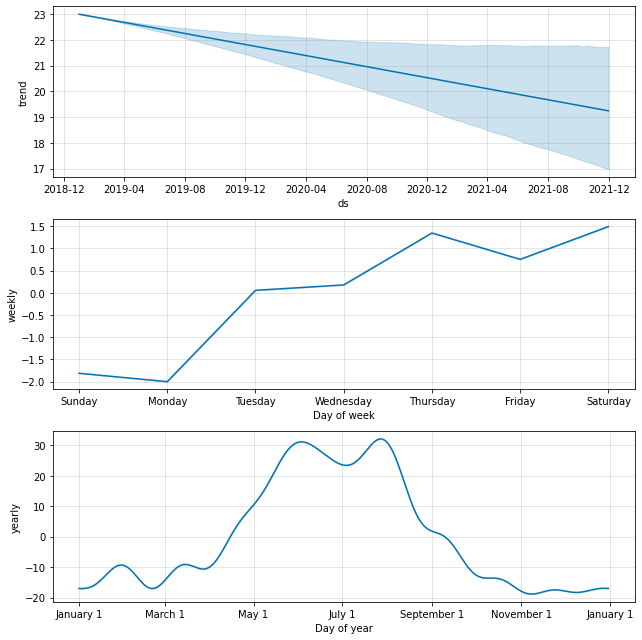

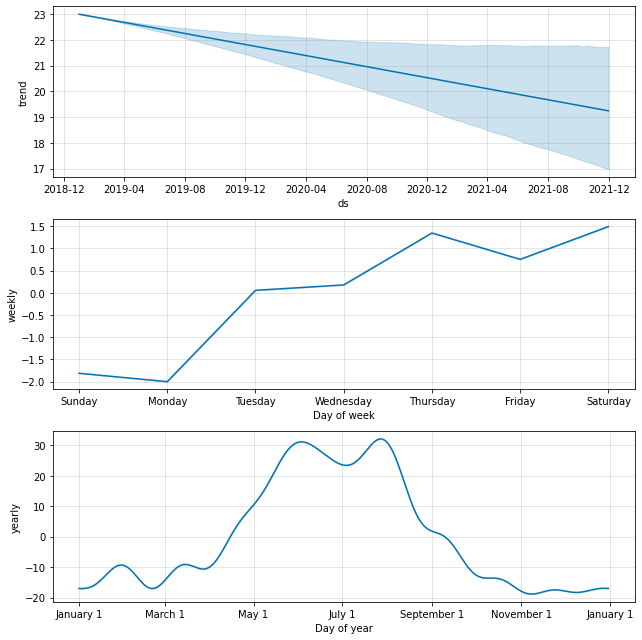

In [128]:
model_Mean.plot_components(forecast_Mean)

#Conclución
Como se pudo observar la viavilidad de los modelos va estrechamente relzacionada con la dispercion de los datos. En este caso en particular, que es una serie de tiempo, tenemos que dependera de esta distribucion si es necesario ajustar los periodos que se usaran (horas, dias, semanas, etc) ya que si la distribucion de los datos es correcta podria no ser necesario ajustar los periodos.
Tambien hay que tener en cuenta los rangos con los que se trabajan, ya que si estos son muy grandes o muy pequeños, los periodos que se usen tambien afectaran de buena o mala forma los resultados, ya que podriamos tener muchos datos o muy pocos.